In [7]:
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import pandas as pd
import numpy as np
import seaborn as sns
import operator
import timeit
import scipy.stats as st
from joblib import Parallel, delayed
import scipy.stats as stats

In [2]:
summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Expected Demand (Lead Time)': [705, 3891, 2266, 785],
    'Annual demand': [28670, 237370, 51831, 13056]
}

In [5]:
start = timeit.default_timer()

class Product:
    def __init__(self, i):
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.demand_lead = summary['Expected Demand (Lead Time)'][i - 1]

        mean_demand = summary['Mean Demand (Lead Time)'][i - 1]
        std_dev_demand = summary['Std. Dev. of Demand (Lead Time)'][i - 1]
        self.mean = np.log(mean_demand) if mean_demand > 0 else 0
        self.sd = np.log(std_dev_demand) if std_dev_demand > 0 else 0

def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS(product, q, r):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability

    order_placed = False
    days_to_arrival = 0
    stock_out = 0

    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if order_placed:
            days_to_arrival -= 1
            if days_to_arrival == 0:
                inventory += q
                order_placed = False

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        else:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        if inventory <= r and not order_placed:
            q = max(q - inventory + product.demand_lead, 0)
            order_placed = True
            days_to_arrival = lead_time
            data['orders'].append(q)

        data['inv_level'].append(inventory)

    return data

def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

def simulation(product, q, r, num_simulations=50):
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = MCS(product, q, r)

        profit = profit_calculation(data, product)
        profit_list.append(profit)

        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders / total_demand if total_demand > 0 else 0)

    return profit_list, orders_lost_list

def continous_review(product, q_guess, r_guess):
    q_low = q_guess - 1000
    q_high = q_guess + 1000
    q_range = [i for i in range(int(q_low), int(q_high), 10)]

    r_low = r_guess - 300
    r_high = r_guess + 300
    r_range = [i for i in range(int(r_low), int(r_high), 10)]

    review_dict = {}

    for q in q_range:
        for r in r_range:
            p_list, o_list = simulation(product, q, r)
            review_dict[(q, r)] = (
                np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict

idx = ['Order-point M', 'Expected Profit', 'Profit Standard Deviation']

low_percent = 0.8   # 80% of starting stock
high_percent = 1.5  # 150% of starting stock

starting_stock_1 = summary['Starting Stock'][0]
starting_stock_2 = summary['Starting Stock'][1]
starting_stock_3 = summary['Starting Stock'][2]
starting_stock_4 = summary['Starting Stock'][3]

low = int(starting_stock_1 * low_percent)
high = int(starting_stock_1 * high_percent)

review = continous_review(Product(1), low, high)
prod_review_1 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_2 * low_percent)
high = int(starting_stock_2 * high_percent)

review = continous_review(Product(2), low, high)
prod_review_2 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_3 * low_percent)
high = int(starting_stock_3 * high_percent)

review = continous_review(Product(3), low, high)
prod_review_3 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_4 * low_percent)
high = int(starting_stock_4 * high_percent)

review = continous_review(Product(4), low, high)
prod_review_4 = max(review.items(), key=operator.itemgetter(1))

df_product_review = pd.DataFrame(
    {'1': [prod_review_1[0], prod_review_1[1][0], prod_review_1[1][3]],
     '2': [prod_review_2[0], prod_review_2[1][0], prod_review_2[1][3]],
     '3': [prod_review_3[0], prod_review_3[1][0], prod_review_3[1][3]],
     '4': [prod_review_4[0], prod_review_4[1][0], prod_review_4[1][3]]},
    index=idx)  

print(df_product_review)

stop = timeit.default_timer()
print('Time: ', stop - start)

                                       1               2              3  \
Order-point M               (2780, 3975)  (18280, 33740)   (4830, 7510)   
Expected Profit            168454.942729   635235.615061  349964.345133   
Profit Standard Deviation  126750.064577    57825.845562  192787.850043   

                                       4  
Order-point M               (2090, 1840)  
Expected Profit            493513.372579  
Profit Standard Deviation   62342.251038  
Time:  4440.919243199998


## grid search
performed a grid search to optimize for maximum profit, best reorder point, best order quantity, mean safety stock, standard deviation of profit, and lost order proportion for each product. Iterated over a range of order quantities (q) and reorder points (r), and then evaluate each combination based on the simulation results.

In [12]:
def simulate_inventory(product, q, r, num_simulations=50):
    results = {'profit': [], 'safety_stock': [], 'std_profit': [], 'lost_order_proportion': []}

    for _ in range(num_simulations):
        inventory = product.starting_stock
        total_revenue = 0
        total_cost = 0
        total_orders = 0
        lost_orders = 0

        for day in range(365):
            mean_demand = product.mean_demand
            std_dev_demand = product.std_dev_demand
            day_demand = daily_demand(mean_demand, std_dev_demand, product.probability)

            if inventory <= r:
                order_quantity = q - inventory
                total_orders += 1
                total_cost += product.ordering_cost
                inventory += order_quantity

            if inventory >= day_demand:
                inventory -= day_demand
                total_revenue += day_demand * product.selling_price
            else:
                lost_orders += day_demand - inventory
                inventory = 0

        profit = total_revenue - total_cost - inventory * product.holding_cost * product.size / 365
        safety_stock = np.mean([max(0, r - daily_demand(product.mean_demand, product.std_dev_demand, product.probability)) for _ in range(100)])
        lost_order_proportion = lost_orders / (product.mean_demand * 365)

        results['profit'].append(profit)
        results['safety_stock'].append(safety_stock)
        results['std_profit'].append(np.std(results['profit']))
        results['lost_order_proportion'].append(lost_order_proportion)

    return results

# Grid search for optimization
def grid_search(product, summary, low_percent=0.8, high_percent=1.5):
    starting_stock = summary['Starting Stock'][product.i - 1]
    q_low = int(low_percent * starting_stock)
    q_high = int(high_percent * starting_stock)
    r_low = 0
    r_high = starting_stock

    best_result = {
        'max_profit': -np.inf,
        'best_q': None,
        'best_r': None,
        'mean_safety_stock': None,
        'std_profit': None,
        'lost_order_proportion': None
    }

    for q in range(q_low, q_high, 500):
        for r in range(r_low, r_high, 500):
            results = simulate_inventory(product, q, r)
            mean_profit = np.mean(results['profit'])
            mean_safety_stock = np.mean(results['safety_stock'])
            mean_std_profit = np.mean(results['std_profit'])
            mean_lost_order_proportion = np.mean(results['lost_order_proportion'])

            if mean_profit > best_result['max_profit']:
                best_result['max_profit'] = mean_profit
                best_result['best_q'] = q
                best_result['best_r'] = r
                best_result['mean_safety_stock'] = mean_safety_stock
                best_result['std_profit'] = mean_std_profit
                best_result['lost_order_proportion'] = mean_lost_order_proportion

    return best_result

results = []

for i in range(1, 5):
    product = Product(i, summary)
    result = grid_search(product, summary)
    results.append(result)

# Output results for each product
for i, result in enumerate(results, start=1):
    print(f"Product {i}:")
    print(f"Max Profit: {result['max_profit']:.2f}")
    print(f"Best Order Quantity (q): {result['best_q']}")
    print(f"Best Reorder Point (r): {result['best_r']}")
    print(f"Mean Safety Stock: {result['mean_safety_stock']:.2f}")
    print(f"Standard Deviation of Profit: {result['std_profit']:.2f}")
    print(f"Lost Order Proportion: {result['lost_order_proportion']:.4f}")
    print()


Product 1:
Max Profit: 455298.75
Best Order Quantity (q): 3200
Best Reorder Point (r): 500
Mean Safety Stock: 421.89
Standard Deviation of Profit: 18893.89
Lost Order Proportion: 0.0000

Product 2:
Max Profit: 2028436.29
Best Order Quantity (q): 32500
Best Reorder Point (r): 1000
Mean Safety Stock: 351.78
Standard Deviation of Profit: 4024.65
Lost Order Proportion: 0.0000

Product 3:
Max Profit: 521983.34
Best Order Quantity (q): 7160
Best Reorder Point (r): 500
Mean Safety Stock: 359.03
Standard Deviation of Profit: 13082.08
Lost Order Proportion: 0.0000

Product 4:
Max Profit: 860626.65
Best Order Quantity (q): 1620
Best Reorder Point (r): 500
Mean Safety Stock: 465.41
Standard Deviation of Profit: 85071.92
Lost Order Proportion: 0.0000



## PDF plot for demand

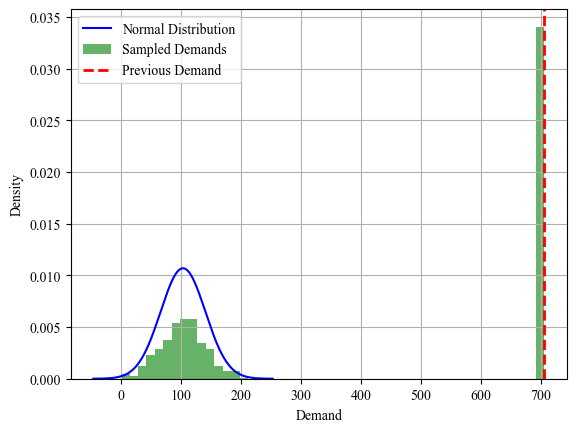

In [8]:
def plot_pdf(mean, sd, samples, prev_demand):
    x = np.linspace(mean - 4*sd, mean + 4*sd, 1000)
    pdf_normal = stats.norm.pdf(x, mean, sd)
    plt.plot(x, pdf_normal, label='Normal Distribution', color='blue')
    plt.hist(samples, bins=50, density=True, alpha=0.6, color='green', label='Sampled Demands')
    plt.axvline(prev_demand, color='red', linestyle='dashed', linewidth=2, label='Previous Demand')
    plt.xlabel('Demand')
    plt.ylabel('Density')
#     plt.title('PDF of Daily Demand with Conditional Sampling')
    plt.legend()
    plt.show()

def generate_samples(mean, sd, num_samples, prev_demand, condition_prob=0.5):
    samples = []
    for _ in range(num_samples):
        condition = np.random.choice([0, 1], p=[1-condition_prob, condition_prob])
        if condition == 1:
            samples.append(prev_demand)
        else:
            samples.append(np.random.normal(mean, sd))
    return samples

product_id = 1 
product = Product(product_id)

mean = product.mean
sd = product.sd
num_samples = 1000
prev_demand = product.demand_lead

samples = generate_samples(mean, sd, num_samples, prev_demand)

plot_pdf(mean, sd, samples, prev_demand)


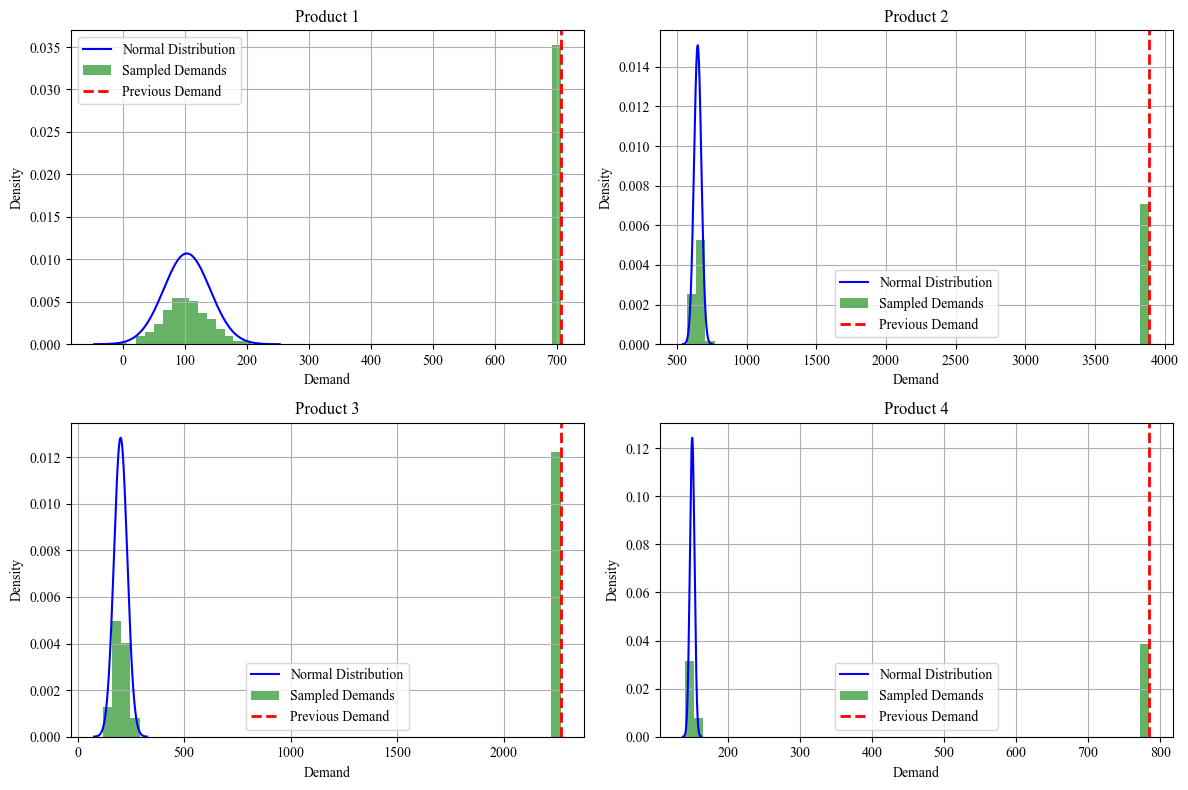

In [11]:
# Number of products
num_products = len(summary['Purchase Cost'])
# Number of samples to generate
num_samples = 1000

plt.figure(figsize=(12, 8))

for i in range(1, num_products + 1):
    product = Product(i)
    mean = product.mean
    sd = product.sd
    prev_demand = product.demand_lead
    
    samples = generate_samples(mean, sd, num_samples, prev_demand)
    
    plot_pdf(mean, sd, samples, prev_demand, i)

plt.tight_layout()
plt.show()
